In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from scipy.stats import loguniform

In [ ]:
df = pd.read_csv('credit_card_data.csv')

df.drop('ID', axis=1, inplace=True)

X = df.drop('dpnm', axis=1)
y = df['dpnm']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Base Linear SVM
base_svm = LinearSVC(
    class_weight='balanced',
    dual=False,
    max_iter=8000,
    random_state=42
)

In [ ]:
param_dist = {
    'C': loguniform(1e-2, 10)
}

random_search = RandomizedSearchCV(
    estimator=base_svm,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Tuning Linear SVM...")
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters:", random_search.best_params_)

Tuning Linear SVM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters: {'C': np.float64(0.014936568554617643)}


In [ ]:
calibrated_svm = CalibratedClassifierCV(
    random_search.best_estimator_,
    method='sigmoid',
    cv=3
)
calibrated_svm.fit(X_train_scaled, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(C=np.float64(0.014936568554617643),
                                           class_weight='balanced', dual=False,
                                           max_iter=8000, random_state=42))

In [ ]:
y_probs = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

threshold = 0.40   # tuned threshold (default is 0.50)
y_pred = (y_probs >= threshold).astype(int)

# 8. Evaluation
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Accuracy ---")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n--- F1 Score (Default Class) ---")
print(f"{f1_score(y_test, y_pred):.4f}")


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.62      0.37      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.68      6000
weighted avg       0.79      0.81      0.79      6000


--- Confusion Matrix ---
[[4377  296]
 [ 836  491]]

--- Accuracy ---
0.8113

--- F1 Score (Default Class) ---
0.4645


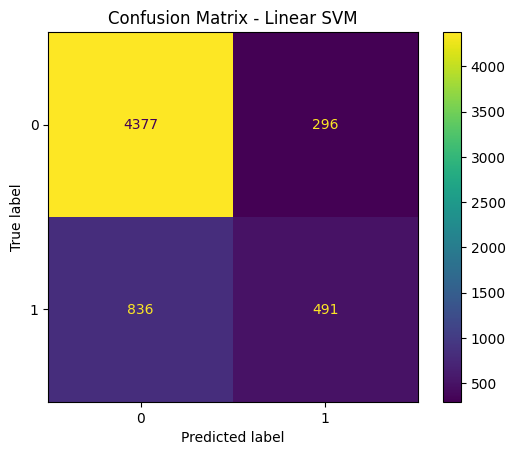

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Linear SVM")
plt.show()

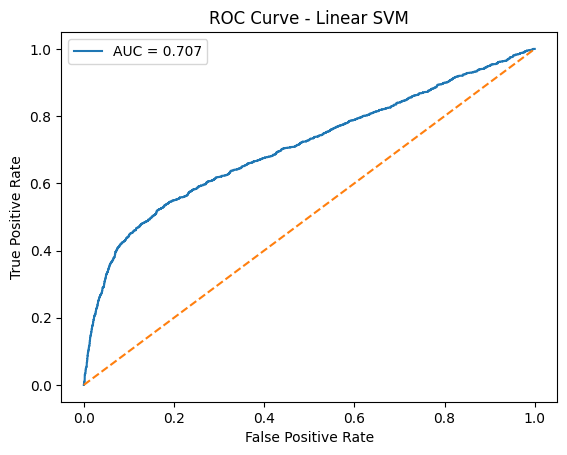

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear SVM")
plt.legend()
plt.show()

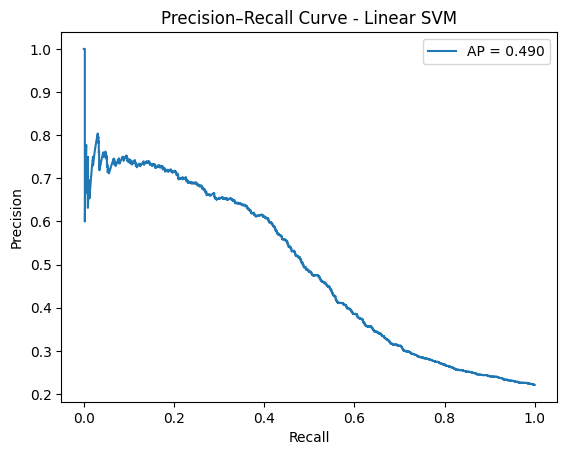

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Linear SVM")
plt.legend()
plt.show()

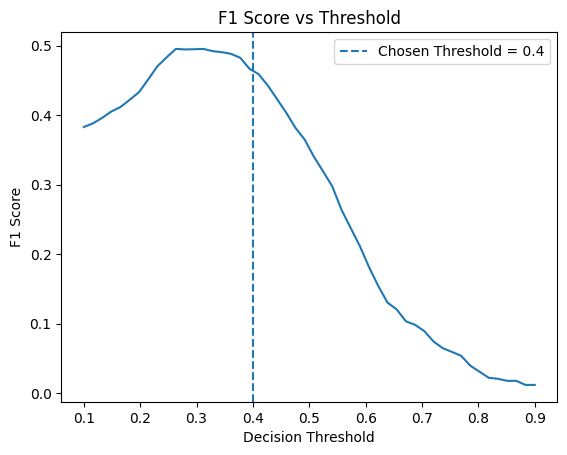

In [ ]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds:
    y_temp = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_temp))

plt.figure()
plt.plot(thresholds, f1_scores)
plt.axvline(x=threshold, linestyle='--', label=f"Chosen Threshold = {threshold}")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.show()